# **PRÁCTICA 3: GANs - Parte 1: GANs simples**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos


## **Ejercicio 1: Modifica el código para incluir la generación de las etiquetas** 

## Importamos librerías 

In [ ]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY

## Cargamos conjunto de datos

Para comenzar, realizaremos la lectura del set de datos. Esta lectura resulta sencilla teniendo en cuenta que Keras, la librería que usaremos para implementar la Red Neuronal, ya contiene una función que fácilmente permite importar el set MNIST.

De igual forma, el módulo mnist permite separar de forma automática este set en entrenamiento (con 60,000 imágenes) y validación (con 10,000):

In [ ]:
from keras import backend as K
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Cada elemento de estos sets contiene cada una de las imágenes (almacenadas en las variables x_train y x_test) y la categoría a la que pertenecen (almacenadas en las variables y_train y y_test).

Como cada imagen tiene un tamaño de 28x28 pixeles, las variables x_train y x_test serán por tanto arreglos de 60000x28x28 y 10000x28x28, mientras que y_train y y_test serán simplemente vectores de 60000 y 10000 elementos respectivamente.

## Visualizamos MNIST

Podemos visualizar algunas imágenes del set de entrenamiento usando las siguientes líneas de código:

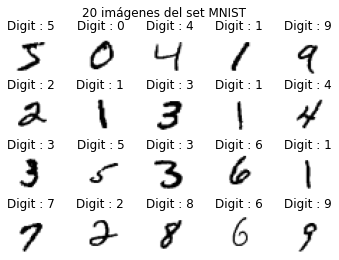

In [ ]:
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(x_train[i],cmap='gray_r')
  plt.title("Digit : {}".format(y_train[i]))
  plt.subplots_adjust(hspace=0.5)
  plt.axis('off')
plt.suptitle('20 imágenes del set MNIST')
plt.show()

## Pre-procesamiento del set de datos


Antes de introducir las imágenes a la Red Neuronal es necesario reajustarlas. Esto debido a que las Redes Neuronales sólo aceptas vectores como datos de entrada, pero cada imagen es una matriz de 28x28 elementos. Así que cada una de estas matrices debe ser convertida a un vector, lo cual se logra fácilmente con la función reshape de Numpy:

In [ ]:
# Rescale -1 to 1
X_train = (x_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
label = (y_train.astype(np.float32) - 4.5) / 4.5

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
label = np.expand_dims(label,-1)

In [ ]:
train_label = np.concatenate((X_train, label), axis = 1)

## Diseñamos modelo

Primero creamos instancias del generador y el discriminador (Dimensiones y optimizador)

In [ ]:
width=28
height=28
channels=1

in_shape = X_train.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Modelo Generador**

Creamos el modelo del Generador, como podemos observar, esto es lo más simple posible, 4 capas completamente conectadas, con normalización por lotes. El generador crea nuevas imágenes tan similares como sea posible a las imágenes en la base de datos.

Hasta ahora lo que tenemos a continuación es que nuestra salida del generador tiene un tamaño de 784. Para añadirle las etiquetas, lo que vamos a ahcer es añadirle una neurona más a nuestro modelo para luego poder generar dichas etiquetas. 

Si hacemos esto, tenemos que quitar el reshape de nuestro modelo ya que ahora ya no le pasamos una imagen completa, si no un vector de 785.

In [ ]:
model_gen = Sequential()
model_gen.add(Dense(256, input_shape=(100,))) # vector de 100 de ruido
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape)+1, # queremos sque sea de una dimensión más
                    activation='tanh')) 
# model_gen.add(Reshape(in_shape)) 

model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

**Modelo Discriminador**

Creamos el modelo del discriminador que como podemos observar es igual de simple que el del generador. El discriminador trata de entender si son imágenes originales o sintéticas.

Ahora no le estamos pasando una imagen al discriminador sino que le estamos pasando un vector con los pixeles de la imagen más el valor que le añadimos para generar etiquetas. Por lo tanto para empezar, no nos interesa tener la capa Flatten ya que no tenemos ninguna imagen sino el vector.

Por otro lado entonces la capa del Dense va a tener como entrada el vector que sale del generador.


In [ ]:
model_Disc = Sequential()
# model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape = (np.prod(in_shape)+1,)))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()

model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100608    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 108,929
Trainable params: 108,929
Non-trainable params: 0
_________________________________________________________________


**Modelo GAN**

Ahora la parte difícil de entender. Vamos a crear el modelo combinado (model_gan en el código), este es solo un generador seguido de un discriminador. Tenga en cuenta que los pesos del discriminador se han congelado, por lo que cuando entrene este modelo, las capas del generador no se verán afectadas y solo transmitirán hacia arriba el gradiente.



In [ ]:
model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 785)               1494545   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 108929    
                                                                 
Total params: 1,603,474
Trainable params: 1,599,890
Non-trainable params: 3,584
_________________________________________________________________


### Entrenamiento

**Entrenando discriminador**

Ahora que ya tenemos nuestras imágenes cargadas, vamos a entrenar el discriminador. Para ello, vamos a necesitar tanto imágenes reales como imágenes ficticias (sintéticas), por lo que crearemos un par de funciones que no generen eso mismo.

De cara a crear imágenes sintéticas es importante tener en cuenta el la forma (shape) de nuestras imágenes. Las imágenes son de 32x32x3, por lo que tendremos que generar n imágenes con esas mismas dimensiones.

Además, vamos a aprovechar para que estas funciones nos devuelvan la etiqueta de nuestros datos. El discriminador va a predecir la probabilidad de que una imagen sea real.

**Entrenando generador**

**Creando nuestra red generativa adversaria**

Ya tenemos todas las piezas de nuestra red generativa adversaria. Por un lado, un clasificador de imágenes ya entrenado que distingue entre imágenes reales y fake y por el otro lado un generador de imágenes. Aunque este último de momento no aprende.

Ahora tenemos que juntar estas dos piezas de tal manera que dados unos datos de entrada el modelo nos devuelva la probabilidad de ser real y que la red generativa se vaya entrenando.

In [ ]:
# Parámetros del entrenamiento
epochs = 5000 
batch = 10
X_train = train_label

# Bucle entrenamiento
DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

for cnt in range(epochs):

    ## Entrenamos discriminador
        # Imágenes reales
    random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
    legit_images = X_train[random_index : random_index + np.int64(batch/2)] 
    #.reshape((np.int64(batch/2),) + in_shape), lo quitamos porque no le pasas una imagen 
        
        # Imágenes sintéticas
    gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
    syntetic_images = model_gen.predict(gen_noise)
        
        # Combinamos imágenes reales y sintéticas
    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
        # Entrenamos discriminador
    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)

    ## Entrenamos generador
        # Imágenes sintéticas
    noise = np.random.normal(0, 1, (batch, 100))
    y_mislabled = np.ones((batch, 1))
        # Entremaos generador
    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    ## Evolución entrenamiento
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss
    

Curvas de aprendizaje

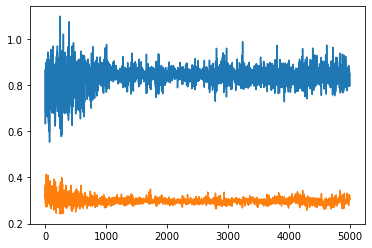

In [ ]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

# Generar datos

In [ ]:
# Generamos imagen sintética
numero = np.int64(20)
gen_noise = np.random.normal(0, 1, (numero, 100))
syntetic_images = model_gen.predict(gen_noise)

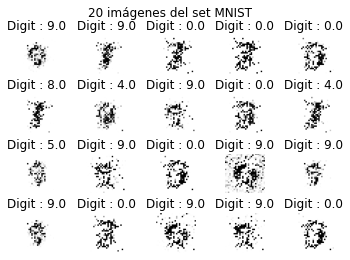

In [ ]:
syntetic_imagenes = syntetic_images[:,0:-1].reshape(numero, 28,28,1)
label = np.around(syntetic_images[:,-1] * 4.5 + 4.5)

for i in range(numero):
  plt.subplot(4,5,i+1)
  plt.imshow(syntetic_imagenes[i].squeeze() ,cmap='gray_r') # gray
  plt.subplots_adjust(hspace=0.5)
  plt.title("Digit : {}".format(label[i]))
  plt.suptitle('20 imágenes del set MNIST')
  plt.axis('off')